In [191]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

# data_netw = pd.read_csv('../data/tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)
# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [193]:
data.head()

,TV_ANE,TV_AMC,TV_ANIMALPLANET,TV_BBCAMERICA,TV_BET,TV_BETHER,TV_BRAVO,TV_COMEDYCENTRAL,TV_COUNTRYMUSICTELEVISION,TV_FOODNETWORK,...,TV_SMITHSONIANNETWORK,TV_SYFY,TV_TRUTV,TV_TVONE,TV_USANETWORK,TV_VH1,TV_WETV,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39,0.0,16
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.00,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0


In [165]:
#data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

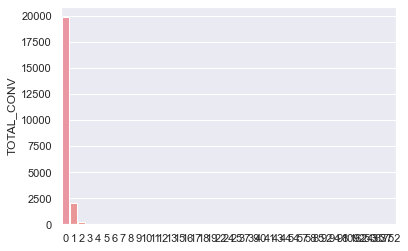

In [194]:
df_count = pd.DataFrame(data.TOTAL_CONV.value_counts())
sns.barplot(x = df_count.index, 
            y = df_count.TOTAL_CONV, )
plt.show()

In [195]:
len(y)

2405

In [187]:
len([v for v in sorted(y) if v == 0.05263157894736842])

2090

<AxesSubplot:ylabel='Count'>

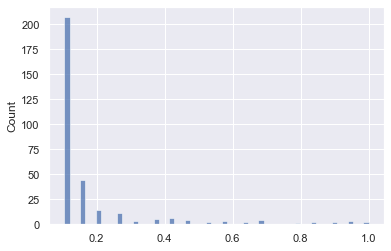

In [189]:
sns.histplot([v for v in sorted(y) if v != 0.05263157894736842])

In [190]:
len([v for v in sorted(y) if v != 0.05263157894736842])

315

In [167]:
# Scaling all data with MinMaxScaler
scaller = MinMaxScaler()
data= pd.DataFrame(scaller.fit_transform(data), columns= data.columns)

In [171]:
data = data[data.TOTAL_CONV>0]

In [172]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

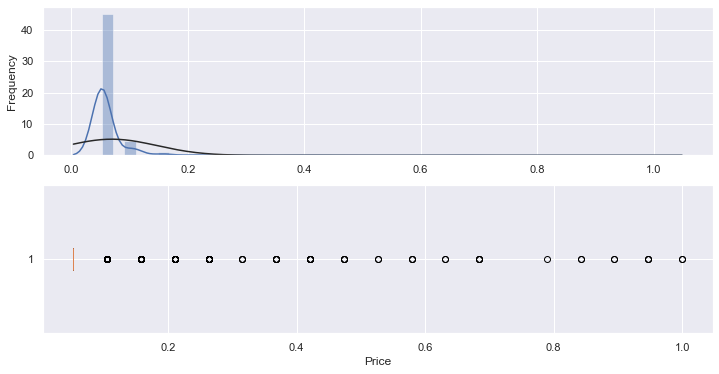

In [180]:
target_distribution(y)

### InverseGamma as Likelihood

In [174]:
with pm.Model() as model_invgamma:
        # Intercept
        alpha = pm.Normal('alpha', mu = y.mean(), sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd = 10, shape = len(data.columns[:-1]))
        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        # Likelihood
        conv = pm.InverseGamma('conv', mu = mu, sigma = eps, observed=y)

        trace_invgamma = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 251 seconds.


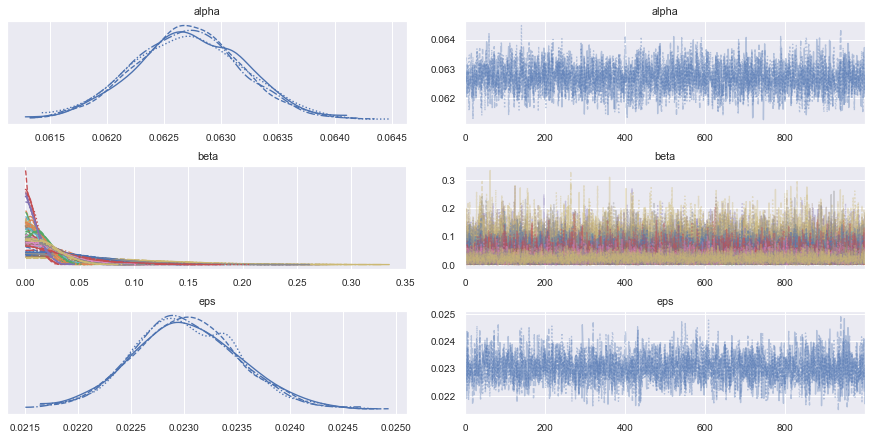

In [175]:
az.plot_trace(trace_invgamma)
plt.show()

In [176]:
az.summary(trace_invgamma, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_ANE,0.020,0.014,0.0,0.045,0.000,0.000,3417.0,1806.0,1.0
TV_AMC,0.028,0.022,0.0,0.067,0.000,0.000,3120.0,1752.0,1.0
TV_ANIMALPLANET,0.020,0.016,0.0,0.049,0.000,0.000,3353.0,1676.0,1.0
TV_BBCAMERICA,0.020,0.016,0.0,0.048,0.000,0.000,1646.0,689.0,1.0
TV_BET,0.058,0.044,0.0,0.136,0.001,0.000,2717.0,1415.0,1.0
TV_BETHER,0.061,0.045,0.0,0.142,0.001,0.000,2961.0,1799.0,1.0
TV_BRAVO,0.021,0.017,0.0,0.052,0.000,0.000,3181.0,2000.0,1.0
TV_COMEDYCENTRAL,0.021,0.015,0.0,0.047,0.000,0.000,2398.0,1615.0,1.0
TV_COUNTRYMUSICTELEVISION,0.079,0.057,0.0,0.180,0.001,0.001,2904.0,1677.0,1.0
TV_FOODNETWORK,0.029,0.022,0.0,0.068,0.000,0.000,2752.0,1751.0,1.0


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


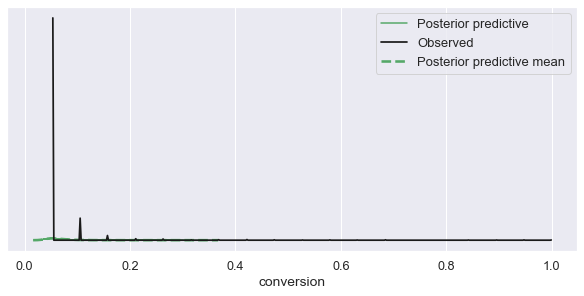

R2 for Model is : 0.009


In [177]:
predictions_chisq = ppc_check(model=model_invgamma, 
                            data = data, 
                            trace= trace_invgamma, 
                            predictions= True)

In [178]:
with pm.Model() as model_log:

        # Intercept
        alpha = pm.Normal('alpha', mu = y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
      
        # Likelihood
        conv = pm.Gamma('conv', 
                       mu = mu, 
                       sigma= eps,  
                       observed=y)

        trace_log = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 310 seconds.


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


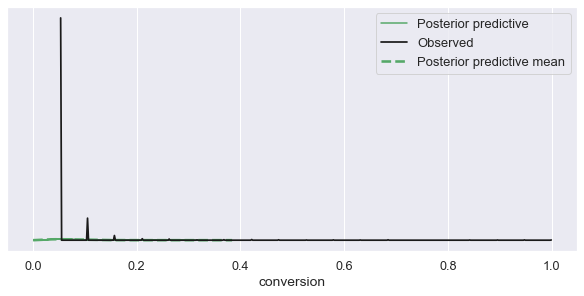

R2 for Model is : 0.011


In [179]:
predictions_log = ppc_check(model=model_log, 
                            data = data, 
                            trace= trace_log, 
                            predictions= True)

### Gamma for Likelihood

In [62]:
with pm.Model() as model_gamma:

        # Intercept
        alpha = pm.Normal('alpha', mu = y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
      
        # Likelihood
        conv = pm.Gamma('conv', 
                       mu = mu, 
                       sigma= eps,  
                       observed=y)

        trace_gamma = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 258 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


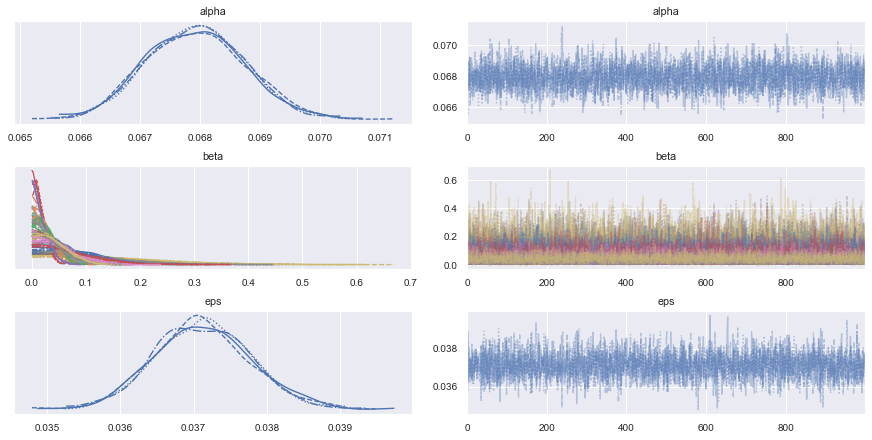

In [63]:
az.plot_trace(trace_gamma)
plt.show()

In [64]:
az.summary(trace_gamma, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_ANE,0.038,0.028,0.0,0.087,0.000,0.000,3290.0,2022.0,1.0
TV_AMC,0.054,0.040,0.0,0.126,0.001,0.000,3179.0,1714.0,1.0
TV_ANIMALPLANET,0.037,0.029,0.0,0.089,0.000,0.000,3480.0,1778.0,1.0
TV_BBCAMERICA,0.038,0.028,0.0,0.089,0.000,0.000,3280.0,1612.0,1.0
TV_BET,0.103,0.078,0.0,0.244,0.001,0.001,3107.0,1557.0,1.0
TV_BETHER,0.112,0.084,0.0,0.262,0.001,0.001,3461.0,1640.0,1.0
TV_BRAVO,0.042,0.032,0.0,0.101,0.000,0.000,3586.0,1948.0,1.0
TV_COMEDYCENTRAL,0.039,0.029,0.0,0.092,0.000,0.000,2777.0,1399.0,1.0
TV_COUNTRYMUSICTELEVISION,0.148,0.105,0.0,0.338,0.002,0.001,2244.0,1278.0,1.0
TV_FOODNETWORK,0.057,0.042,0.0,0.129,0.001,0.000,3776.0,1897.0,1.0


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


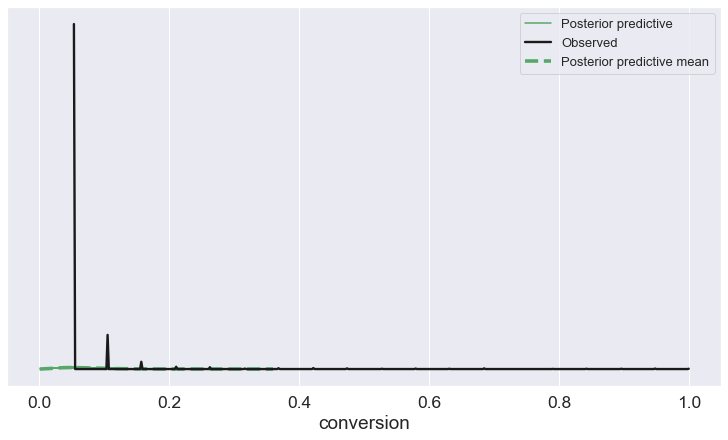

R2 for Model is : 0.011


In [81]:
predictions_gamma = ppc_check(model=model_gamma, 
                            data = data, 
                            trace= trace_gamma, 
                            predictions= True)

### TtuncatedNorman as Likelihood

In [76]:
with pm.Model() as model_tranc:

        # Intercept
        alpha = pm.Normal('alpha', mu = y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
      
        # Likelihood
        conv = pm.TruncatedNormal('conv', 
                                   mu = mu, 
                                   sigma= eps,  
                                   lower = y.min(),
                                   upper = y.max(),
                                   observed=y)

        trace_tranc = pm.sample(chains = 4, target_accept = 0.9)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 570 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [77]:
az.summary(trace_tranc, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_ANE,14.736,16.805,0.012,45.278,3.242,2.318,23.0,1849.0,1.12
TV_AMC,17.938,21.900,0.030,57.813,4.149,2.965,18.0,1460.0,1.15
TV_ANIMALPLANET,15.608,16.905,0.020,46.769,2.711,1.932,76.0,1684.0,1.14
TV_BBCAMERICA,18.803,23.085,0.003,61.974,5.340,3.836,8.0,54.0,1.44
TV_BET,41.927,50.386,0.055,138.008,11.656,8.374,8.0,109.0,1.40
TV_BETHER,84.860,84.799,0.053,247.830,22.614,16.334,10.0,169.0,1.32
TV_BRAVO,25.136,21.777,0.077,66.808,0.365,0.817,2799.0,1547.0,1.53
TV_COMEDYCENTRAL,14.794,18.292,0.002,48.433,3.772,2.701,12.0,1052.0,1.24
TV_COUNTRYMUSICTELEVISION,44.005,51.993,0.027,139.478,9.849,7.039,22.0,1305.0,1.12
TV_FOODNETWORK,21.735,26.238,0.005,70.635,5.661,4.059,12.0,1380.0,1.25


posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


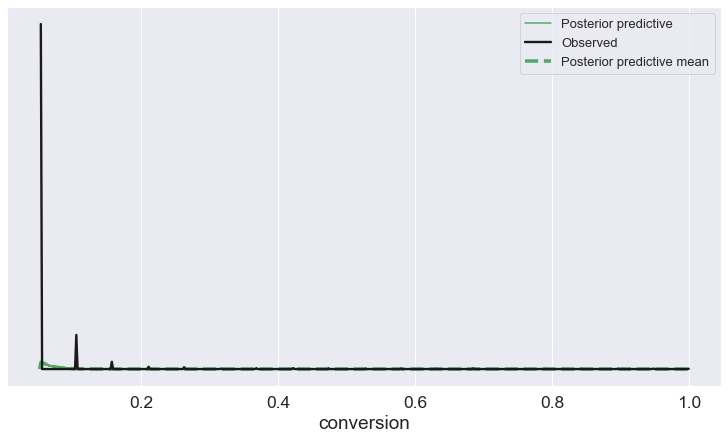

R2 for Model is : 0.525


In [80]:
predictions_tranc = ppc_check(model=model_tranc, 
                            data = data, 
                            trace= trace_tranc, 
                            predictions= True)

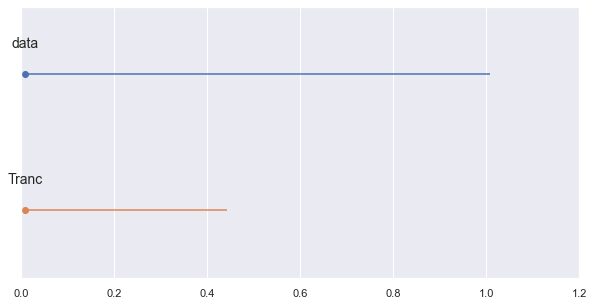

In [39]:
plt.figure(figsize=(10, 5))
ppc_data = [y, 
           # predictions_gamma['conv'], 
            predictions_tranc['conv'], 
           ]

labels = ['data', 'Tranc',]
for i, d in enumerate(ppc_data):
    mean = d.mean()
    err = np.percentile(d, [0, 100])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    plt.ylim([-i-0.5, 0.5])
    plt.xlim([0, 1.2])
    plt.yticks([])

In [84]:
az.convert_to_inference_data(trace_zero_poisson)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [85]:
cmp_df = az.compare({'Gamma':trace_gamma, 
                     'Tranc':trace_tranc,}, 
                   # method='BB-pseudo-BMA'
                   )
cmp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Gamma,0,4730.976171,23.150284,0.000000,1.0,149.295940,0.00000,True,log
Tranc,1,2667.758303,5359.755785,2063.217867,0.0,204.672265,64.41014,True,log


In [40]:
az.waic(trace_exp)

Computed from 4000 by 22272 log-likelihood matrix

          Estimate       SE
elpd_waic 99068.64   844.88
p_waic      827.54        -

There has been a warning during the calculation. Please check the results.

In [50]:
with pm.Model() as model_exp:

        # Intercept
        alpha = pm.Normal('alpha', mu = y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        #f = pm.Exponential()
        # Likelihood
        conv = pm.Exponential('conv', lam = mu, observed=y)

        trace_exp = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 979 seconds.


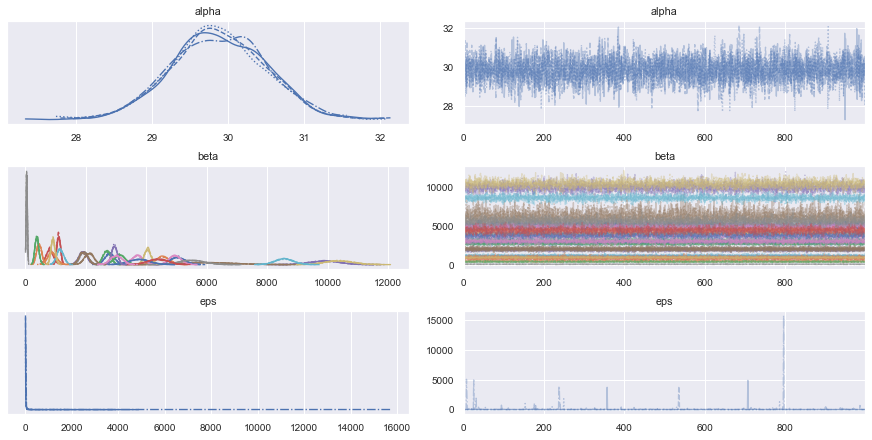

In [51]:
az.plot_trace(trace_exp)
plt.show()

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


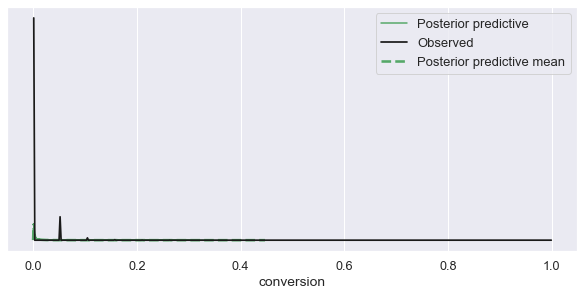

R2 for Model is : 0.71


In [52]:
predictions_exp = ppc_check(model=model_exp, 
                            data = data, 
                            trace= trace_exp, 
                            predictions= True)

In [58]:
coeff = az.summary(trace_exp, var_names = 'beta').set_index(data.columns[:-1])['mean']

<BarContainer object of 29 artists>

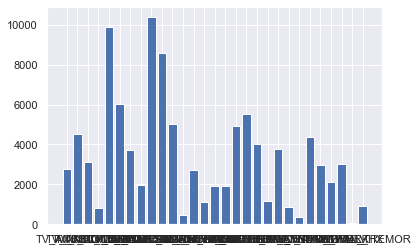

In [61]:
plt.bar(coeff.index, coeff)

In [54]:
for v in predictions_exp['conv']:
    print(v.max())

0.23208697156206198
0.22278931268240978
0.32970439571952104
0.24406112376355268
0.21566117722019665
0.2225798598972476
0.3115501584993595
0.2750531412217338
0.2686276206036494
0.2511542076539469
0.2887934965185807
0.33779697534434705
0.3321427597719337
0.34108880444719625
0.2678282127454242
0.22885626584721575
0.29949214662072915
0.22085101553486178
0.23920780389269922
0.27821079987573455
0.2790256386964076
0.23884182004457513
0.2503117224724969
0.3333102499918683
0.26104071095755355
0.28491423046582365
0.21371293508927752
0.2693941436009732
0.24494351899066347
0.2744591766436454
0.27104112024545807
0.2604712190476445
0.35870835470155654
0.3123079286528017
0.2188052872227196
0.24915502189820982
0.2537406787111121
0.30208416998249976
0.23761941032254685
0.2621007117092561
0.3083923203466183
0.2512574603306848
0.24867295075140922
0.31200885936098277
0.2767449136377055
0.23032669599295466
0.21826561650156243
0.21463883298978156
0.24495394599793108
0.18936659418725008
0.30044393873177044
0

In [37]:
y.max()

1.0